In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#import matplotlib

import pandas as pd
import numpy as np
import durationpy
import math
from os.path import join
from collections import defaultdict


In [2]:
plt.style.use('ggplot')

COLORS_DEFAULT ={'blue': '#348ABD', 'red': '#E24A33'}

In [3]:
# conda install -c phlya adjusttext 
from adjustText import adjust_text

## csv result files directory name and file names

In [4]:
CSV_RESULT_DIR = "../wasm-engines/testresults"

WASM_RESULT_FILE = "standalone_wasm_results.csv"
NATIVE_RESULT_FILE = "native_benchmarks.csv"




## To add a new engine, add the engine name used in the csv file to this list

In [5]:
INTERPRETER_ENGINES = ['life', 'wagon', 'wasmi', 'wabt', 'v8-interpreter', 'wasm3', 'wamr']
COMPILER_ENGINES = ['lifePolymerase', 'wasmtime', 'wavm', 'v8-liftoff', 'v8-turbofan', 'asmble']

wasm_vm_names = INTERPRETER_ENGINES + COMPILER_ENGINES

## Helper funcs

In [6]:
def toMs(secs):
    if secs < 0.001:
        μs = secs * 1000000
        return "{}μs".format(round(μs, 1))
    if secs < 0.1:
        ms = secs * 1000
        return "{}ms".format(round(ms, 1))
    elif secs < 1:
        ms = secs * 1000
        return "{}ms".format(int(round(ms, 0)))
    else:
        return "{}s".format(round(secs, 2))

In [7]:
def labelBarHeights(ax, to_ms=True, small=False, to_factor=False, lower_y_bound=True):
    labels = []
    for p in ax.patches:
        if p.get_height() == 0:
            continue
        label_val = p.get_height()
        #print("height:", p.get_height())
        y_pos = p.get_y() + label_val
        #y_offset = -10
        y_offset = 0
        y_bound = ax.get_ybound()[1]
        if y_pos > y_bound:
            y_pos = y_bound
        #if label_val < (0.03 * y_bound):
            # if bar is too small to fit text, place above the bar
            #y_offset = 5
        if lower_y_bound:
            if label_val < (0.03 * y_bound) and small is False:
                # don't place labels near bottom axis, adjust_text cant deal
                y_offset = 0.03 * y_bound
        
        if label_val > 1000:
            label_val = int(label_val)
        if to_ms:
            label_val = toMs(label_val)
        if to_factor:
            if not isinstance(to_factor, int):
                to_factor = 2
            label_val = str(round(label_val, to_factor)) + "x"
        """
        txt_label = ax.annotate(toMs(label_val),
                    (p.get_x()+p.get_width()/2.,
                     y_pos),
                    ha='center',
                    va='center',
                    xytext=(0, y_offset),
                    textcoords='offset points',
                    fontsize=10,
                    weight="bold")
        """
 
        txt_label = ax.text(
                    x=p.get_x()+p.get_width()/2.,
                    y=y_pos+y_offset,
                    s=label_val,
                    ha='center',
                    va='center',
                    #xytext=(0, y_offset),
                    #textcoords='offset points',
                    fontsize=10,
                    weight="bold")

        labels.append(txt_label)

    #adjust_text(labels, ax=ax)
    return labels

In [8]:
def labelBarWidths(ax, to_ms=True, to_factor=False, to_kb=False, round_places=None):
    for p in ax.patches:
        label_val = p.get_width()
        if label_val == 0:
            continue
        #print("bar width:", label_val)
        x_pos = p.get_x() + label_val
        x_offset = -30
        x_bound = ax.get_xbound()[1]
        if (x_pos > x_bound):
            x_pos = x_bound
        #if label_val < (0.25 * x_bound):
        if label_val < (0.15 * x_bound):
            # if bar is too small to fit text, place next to bar
            x_offset = 30
        if label_val > 1000:
            label_val = int(label_val)
        if to_ms:
            label_val = toMs(label_val)
        if to_factor:
            label_val = str(round(label_val, 2)) + "x"
        if to_kb:
            kbs = label_val / 1000.0
            label_val = str(round(kbs, 1)) + " kB"
        if round_places:
            label_val = str(round(label_val, round_places))
        ax.annotate(label_val,
                    (x_pos,
                     p.get_y()+p.get_height()/2.),
                    ha='center',
                    va='center',
                    xytext=(x_offset, 0),
                    textcoords='offset points',
                    fontsize=10,
                    weight="bold")


In [9]:
def adjust_text_labels(labels, ax=None):
    adjust_text(labels, ax=ax, autoalign='y', only_move={'points':'y', 'text':'y'})
                       

In [10]:
def read_results(file_name):
    results = defaultdict(list)
    csv_results = pd.read_csv(file_name)    
    return csv_results

### Import wasm results

In [11]:
df_wasm = read_results(join(CSV_RESULT_DIR, WASM_RESULT_FILE))


In [12]:
df_wasm

,engine,test_name,elapsed_time,compile_time,exec_time
0,wagon,blake2b-2805-bytes,0.201667,0.062819,0.003182
1,wagon,blake2b-2805-bytes,0.042968,0.037020,0.003207
2,wagon,blake2b-2805-bytes,0.043371,0.037460,0.003195
3,wagon,blake2b-2805-bytes,0.043002,0.037107,0.003196
4,wagon,blake2b-2805-bytes,0.043477,0.037669,0.003180
...,...,...,...,...,...
14002,wasm3,sha1-42488-bits,0.003528,0.000008,0.001249
14003,wasm3,sha1-42488-bits,0.003560,0.000012,0.001128
14004,wasm3,sha1-42488-bits,0.003282,0.000012,0.001131
14005,wasm3,sha1-42488-bits,0.003298,0.000011,0.001127


### Import native results

In [13]:
df_native_raw = read_results(join(CSV_RESULT_DIR, NATIVE_RESULT_FILE))

In [14]:
df_native_raw

,test_name,elapsed_times,native_file_size
0,blake2b-8415-bytes,"5.0454e-05, 5.9824e-05, 5.3892e-05, 3.4696e-05...",980536
1,blake2b-5610-bytes,"3.1285e-05, 3.1146e-05, 3.8032e-05, 3.383e-05,...",980536
2,blake2b-2805-bytes,"2.3027e-05, 1.6652e-05, 1.832e-05, 1.1453e-05,...",886064
3,bls12-381-aggreg-128-pubkeys-verify-sig,"0.020448396, 0.020558415, 0.020397644, 0.02044...",1247808
4,bls12-381-aggreg-64-pubkeys-verify-sig,"0.040975088, 0.014924707, 0.023542334, 0.01454...",1243712
5,bls12-381-aggreg-32-pubkeys-verify-sig,"0.021381894, 0.014551074, 0.017834293, 0.01284...",1243712
6,bn128_add-cdetrio11,"1.158e-05, 1.0761e-05, 1.0772e-05, 1.0466e-05,...",890136
7,bn128_add-cdetrio14,"2.844e-06, 2.747e-06, 2.752e-06, 3.117e-06, 3....",890136
8,bn128_add-cdetrio10,"1.666e-06, 1.822e-06, 1.564e-06, 1.653e-06, 1....",890136
9,bn128_mul-cdetrio11,"0.000310754, 0.000467518, 0.000308115, 0.00029...",894280


In [15]:
native_results = {}
for i in range(len(df_native_raw)):
    test_name = df_native_raw['test_name'][i]
    native_results[test_name] = df_native_raw['elapsed_times'][i].split(', ')


In [16]:
test_names = df_native_raw['test_name'].tolist()

In [17]:
native_times = {}
for test in test_names:
    avg = np.mean([float(t) for t in native_results[test]])
    native_times[test] = avg
    


In [18]:
df_native = pd.DataFrame.from_dict(native_times, orient='index', columns=['elapsed_time'])

In [19]:
df_native

,elapsed_time
blake2b-8415-bytes,0.000018
blake2b-5610-bytes,0.000013
blake2b-2805-bytes,0.000007
bls12-381-aggreg-128-pubkeys-verify-sig,0.020868
bls12-381-aggreg-64-pubkeys-verify-sig,0.015334
bls12-381-aggreg-32-pubkeys-verify-sig,0.012527
bn128_add-cdetrio11,0.000012
bn128_add-cdetrio14,0.000003
bn128_add-cdetrio10,0.000002
bn128_mul-cdetrio11,0.000322


### sorted lists of test names for plotting inputs in order

In [20]:
blake2b_test_names = [name for name in df_wasm['test_name'].unique().tolist() if 'blake2b' in name]
blake2b_test_names.sort()
blake2b_test_names_desc = blake2b_test_names.copy()
blake2b_test_names_desc.reverse()


In [21]:
sha1_test_names = [name for name in df_wasm['test_name'].unique().tolist() if 'sha1' in name]
sha1_test_names.sort()
sha1_test_names_desc = sha1_test_names.copy()
sha1_test_names_desc.reverse()


In [22]:

bn128_mul_test_names = ['bn128_mul-cdetrio11', 'bn128_mul-chfast2', 'bn128_mul-chfast1']
bn128_add_test_names = ['bn128_add-cdetrio11', 'bn128_add-cdetrio14', 'bn128_add-cdetrio10']
bn128_pairing_test_names = ['bn128_pairing-ten_point_match_1', 'bn128_pairing-two_point_match_2', 'bn128_pairing-one_point']

bn128_mul_test_names.reverse()
bn128_add_test_names.reverse()
bn128_pairing_test_names.reverse()

bn128_mul_test_names_desc = ['bn128_mul-cdetrio11', 'bn128_mul-chfast2', 'bn128_mul-chfast1']
bn128_add_test_names_desc = ['bn128_add-cdetrio11', 'bn128_add-cdetrio14', 'bn128_add-cdetrio10']
bn128_pairing_test_names_desc = ['bn128_pairing-ten_point_match_1', 'bn128_pairing-two_point_match_2', 'bn128_pairing-one_point']



In [23]:
bls12_test_names = ['bls12-381-aggreg-32-pubkeys-verify-sig', 'bls12-381-aggreg-64-pubkeys-verify-sig', 'bls12-381-aggreg-128-pubkeys-verify-sig']
bls12_test_names_desc = bls12_test_names.copy()
bls12_test_names_desc.reverse()

In [24]:
modexp_test_names = [name for name in df_wasm['test_name'].unique().tolist() if 'modexp' in name]
modexp_test_names.sort()
modexp_test_names_desc = modexp_test_names.copy()
modexp_test_names_desc.reverse()

In [25]:
all_tests = sha1_test_names + blake2b_test_names + modexp_test_names + ['ed25519-verify-ten-inputs'] + bls12_test_names \
    + bn128_add_test_names + bn128_mul_test_names + bn128_pairing_test_names

### Prepare interpreter dataframe

In [26]:
df_wasm

,engine,test_name,elapsed_time,compile_time,exec_time
0,wagon,blake2b-2805-bytes,0.201667,0.062819,0.003182
1,wagon,blake2b-2805-bytes,0.042968,0.037020,0.003207
2,wagon,blake2b-2805-bytes,0.043371,0.037460,0.003195
3,wagon,blake2b-2805-bytes,0.043002,0.037107,0.003196
4,wagon,blake2b-2805-bytes,0.043477,0.037669,0.003180
...,...,...,...,...,...
14002,wasm3,sha1-42488-bits,0.003528,0.000008,0.001249
14003,wasm3,sha1-42488-bits,0.003560,0.000012,0.001128
14004,wasm3,sha1-42488-bits,0.003282,0.000012,0.001131
14005,wasm3,sha1-42488-bits,0.003298,0.000011,0.001127


In [27]:
interp_results_for_df = []
for engine in INTERPRETER_ENGINES:
    df_engine = df_wasm[df_wasm['engine'] == engine]
    df_means = df_engine.groupby(['test_name']).mean()
    test_names = df_engine['test_name'].unique().tolist()
    for test_name in test_names:
        interp_results_for_df.append([engine, test_name] + df_means.loc[test_name].tolist())


In [28]:
#interp_results_for_df

In [29]:
df_interp = pd.DataFrame(interp_results_for_df)

In [30]:
df_interp.columns = ['engine', 'test_name', 'elapsed_time', 'parse_time', 'exec_time']

In [31]:
df_interp.set_index('engine', inplace=True)

In [32]:
df_interp['total_time'] = df_interp['parse_time'] + df_interp['exec_time']

In [33]:
df_interp

,test_name,elapsed_time,parse_time,exec_time,total_time
engine,,,,,
life,blake2b-2805-bytes,0.017166,0.011548,0.002295,0.013843
life,blake2b-5610-bytes,0.020254,0.012456,0.004519,0.016975
life,blake2b-8415-bytes,0.023375,0.013703,0.006606,0.020309
life,bn128_add-cdetrio10,0.038624,0.034535,0.000660,0.035195
life,bn128_add-cdetrio11,0.044855,0.035998,0.005370,0.041368
...,...,...,...,...,...
wamr,modexp-nagydani-1-qube,0.026484,0.000482,0.019319,0.019801
wamr,modexp-nagydani-1-square,0.025273,0.000481,0.018127,0.018608
wamr,sha1-10808-bits,0.003115,0.000473,0.000575,0.001048


## Interpreter engines compared

In [34]:
def plotInterpThreeTests(df_testdata, three_names, title="Title"):
    df_1 = df_testdata[df_testdata['test_name'] == three_names[0]]
    df_2 = df_testdata[df_testdata['test_name'] == three_names[1]]
    df_3 = df_testdata[df_testdata['test_name'] == three_names[2]]
    plt.figure()
    f, (ax1) = plt.subplots(1, 3, sharey=True, figsize=(16,7))
    df_1.sort_values('total_time')[['parse_time', 'exec_time']].plot.bar(ax=ax1[0], stacked=True)
    ax1[0].set_title(three_names[0])
    ax1[0].set(xlabel='')
    df_2.sort_values('total_time')[['parse_time', 'exec_time']].plot.bar(ax=ax1[1], stacked=True)
    ax1[1].set_title(three_names[1])
    ax1[1].set(xlabel='')
    df_3.sort_values('total_time')[['parse_time', 'exec_time']].plot.bar(ax=ax1[2], stacked=True)
    ax1[2].set_title(three_names[2])
    ax1[2].set(xlabel='')
    adjust_text_labels(labelBarHeights(ax1[0]), ax=ax1[0])
    adjust_text_labels(labelBarHeights(ax1[1]), ax=ax1[1])
    adjust_text_labels(labelBarHeights(ax1[2]), ax=ax1[2])
    ax1[0].legend(labels=["startup time", "execution time"])
    ax1[1].legend(labels=["startup time", "execution time"])
    ax1[2].legend(labels=["startup time", "execution time"])

    ax1[1].tick_params(axis='y', left=True, labelleft=True)
    ax1[2].tick_params(axis='y', left=True, labelleft=True)
    
    scale_y = 1e-3
    ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/scale_y))
    ax1[1].yaxis.set_major_formatter(ticks_y)
    
    ax1[0].set(ylabel='milliseconds')
    
    f.suptitle(title, fontsize=16, y=0.98)
    plt.show()

<Figure size 432x288 with 0 Axes>

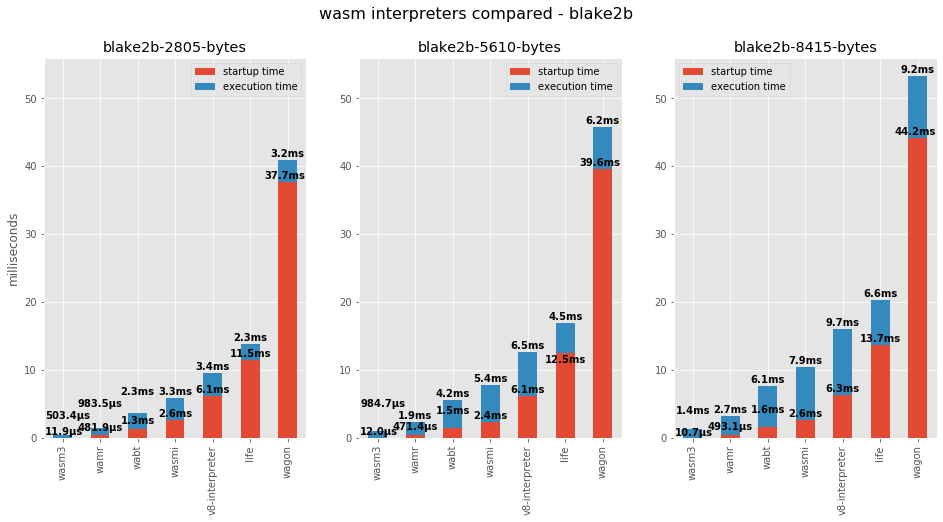

In [35]:
plotInterpThreeTests(df_interp, blake2b_test_names, title="wasm interpreters compared - blake2b")

### Interpreters - Execution time

In [36]:
def plotThreeTestsExecTime(df_testdata, three_names, title="Title"):
    df_1 = df_testdata[df_testdata['test_name'] == three_names[0]]
    df_2 = df_testdata[df_testdata['test_name'] == three_names[1]]
    df_3 = df_testdata[df_testdata['test_name'] == three_names[2]]
    plt.figure()
    f, (ax1) = plt.subplots(1, 3, sharey=True, figsize=(16,7))
    df_1.sort_values('exec_time')[['exec_time']].plot.bar(ax=ax1[0], color=COLORS_DEFAULT['blue'])
    ax1[0].set_title(three_names[0])
    ax1[0].set(xlabel='')
    df_2.sort_values('exec_time')[['exec_time']].plot.bar(ax=ax1[1], color=COLORS_DEFAULT['blue'])
    ax1[1].set_title(three_names[1])
    ax1[1].set(xlabel='')
    df_3.sort_values('exec_time')[['exec_time']].plot.bar(ax=ax1[2], color=COLORS_DEFAULT['blue'])
    ax1[2].set_title(three_names[2])
    ax1[2].set(xlabel='')
    adjust_text_labels(labelBarHeights(ax1[0]), ax=ax1[0])
    adjust_text_labels(labelBarHeights(ax1[1]), ax=ax1[1])
    adjust_text_labels(labelBarHeights(ax1[2]), ax=ax1[2])
    ax1[0].legend(labels=["execution time"])
    ax1[1].legend(labels=["execution time"])
    ax1[2].legend(labels=["execution time"])

    ax1[1].tick_params(axis='y', left=True, labelleft=True)
    ax1[2].tick_params(axis='y', left=True, labelleft=True)
   
    scale_y = 1e-3
    ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/scale_y))
    ax1[1].yaxis.set_major_formatter(ticks_y)
    
    ax1[0].set(ylabel='milliseconds')
    
    f.suptitle(title, fontsize=16, y=0.98)
    plt.show()


<Figure size 432x288 with 0 Axes>

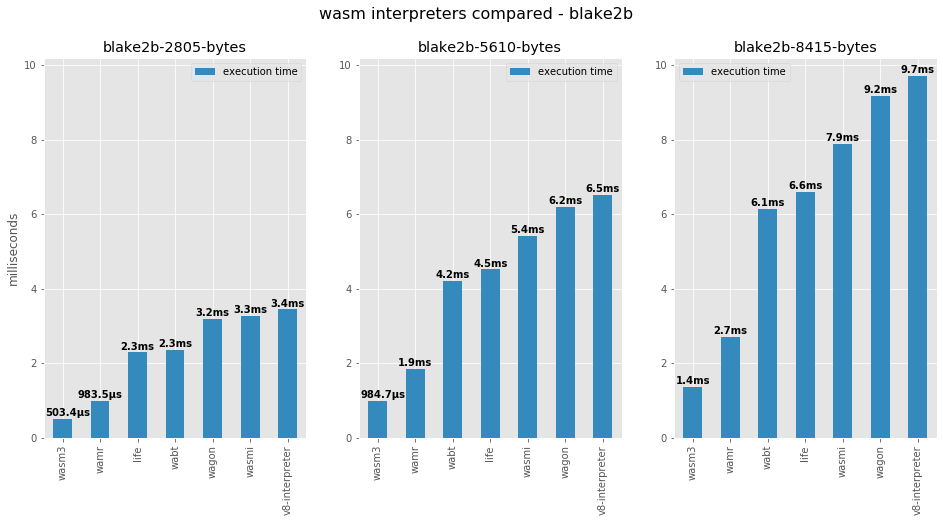

In [37]:
plotThreeTestsExecTime(df_interp, blake2b_test_names, title="wasm interpreters compared - blake2b")

## Compiler Results

In [38]:
compiler_results_for_df = []
for engine in COMPILER_ENGINES:
    df_engine = df_wasm[df_wasm['engine'] == engine]
    df_means = df_engine.groupby(['test_name']).mean()
    test_names = df_engine['test_name'].unique().tolist()
    for test_name in test_names:
        compiler_results_for_df.append([engine, test_name] + df_means.loc[test_name].tolist())

In [39]:
df_compiler = pd.DataFrame(compiler_results_for_df)

In [40]:
df_compiler

,0,1,2,3,4
0,wasmtime,blake2b-2805-bytes,0.097376,0.089052,0.000095
1,wasmtime,blake2b-5610-bytes,0.156181,0.150099,0.000120
2,wasmtime,blake2b-8415-bytes,0.263482,0.257363,0.000144
3,wasmtime,bls12-381-aggreg-128-pubkeys-verify-sig,13.705385,13.361833,0.335880
4,wasmtime,bls12-381-aggreg-32-pubkeys-verify-sig,13.398554,13.220356,0.170188
...,...,...,...,...,...
116,v8-turbofan,modexp-nagydani-1-qube,0.110500,0.042569,0.000080
117,v8-turbofan,modexp-nagydani-1-square,0.110993,0.042689,0.000078
118,v8-turbofan,sha1-10808-bits,0.074094,0.006242,0.000018
119,v8-turbofan,sha1-21896-bits,0.075299,0.007686,0.000023


In [41]:
df_compiler.columns = ['engine', 'test_name', 'elapsed_time', 'compile_time', 'exec_time']

In [42]:
df_compiler.set_index('engine', inplace=True)

In [43]:
df_compiler['total_time'] = df_compiler['compile_time'] + df_compiler['exec_time']

In [44]:
df_compiler

,test_name,elapsed_time,compile_time,exec_time,total_time
engine,,,,,
wasmtime,blake2b-2805-bytes,0.097376,0.089052,0.000095,0.089147
wasmtime,blake2b-5610-bytes,0.156181,0.150099,0.000120,0.150219
wasmtime,blake2b-8415-bytes,0.263482,0.257363,0.000144,0.257508
wasmtime,bls12-381-aggreg-128-pubkeys-verify-sig,13.705385,13.361833,0.335880,13.697713
wasmtime,bls12-381-aggreg-32-pubkeys-verify-sig,13.398554,13.220356,0.170188,13.390544
...,...,...,...,...,...
v8-turbofan,modexp-nagydani-1-qube,0.110500,0.042569,0.000080,0.042649
v8-turbofan,modexp-nagydani-1-square,0.110993,0.042689,0.000078,0.042767
v8-turbofan,sha1-10808-bits,0.074094,0.006242,0.000018,0.006260


## Delete this part

In [45]:
#compiler_results_for_df

In [46]:
liftoff_results = []
for cr in compiler_results_for_df:
    if cr[0] == 'v8-liftoff':
        liftoff_results.append(cr)

In [47]:
#liftoff_results

## Compiler function

*Note: Fix scale for v8-turbofan execution time*

In [48]:
def plotCompilerStackedOneTest(df_benchdata, test_name):
    df_1 = df_benchdata[df_benchdata['test_name'] == test_name]
    # for some reason, exec_time needs to come first for the stacked chart to display correctly
    ax = df_1[['exec_time', 'compile_time']].sort_values('exec_time').plot.bar(stacked=True, color=[COLORS_DEFAULT['blue'], COLORS_DEFAULT['red']], figsize=(10,10))
    ax.set_title("Compilers - {}".format(test_name))
    df_total_times = df_1[['exec_time', 'compile_time']].copy()
    df_total_times['total_time'] = df_total_times['exec_time'] + df_total_times['compile_time']
    ymax = max(df_total_times[['total_time']].max()) * 1.3 # 30% larger for padding between top of bars and top of graph
    ymin = min([x for x in df_1[['exec_time', 'compile_time']].min().tolist() if x > 0])
    ymin = ymin * 0.8 # 0.8 to get a number 20% smaller, fix to make bar appear for smallest exec time
    ax.set_ylim(ymin, ymax)
    ax.set_yscale("log")
    plt.ylabel("seconds (log scale)")
    adjust_text_labels(labelBarHeights(ax, lower_y_bound=False))
    ax.legend(labels=["execution time", "compile time"])
    plt.savefig("../images/wasm-compilers.png")



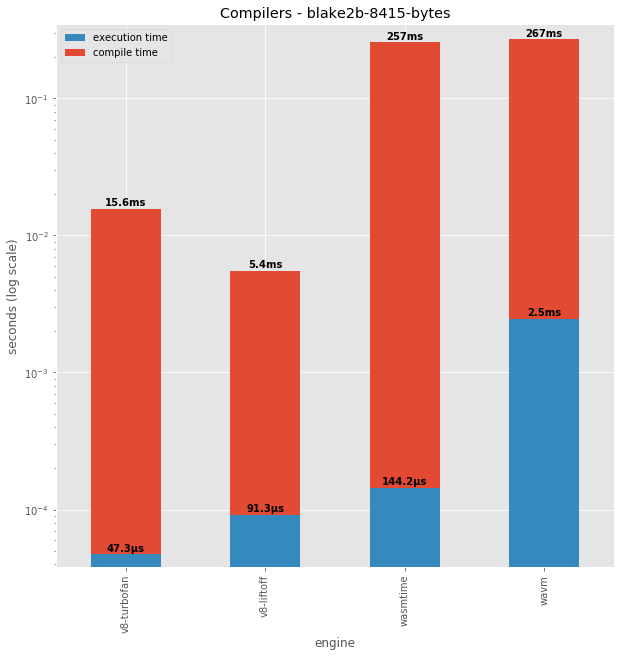

In [49]:
plotCompilerStackedOneTest(df_compiler, blake2b_test_names[2])

## Interpreter vs Compiler speedup

In [50]:
df_interp_merge = df_interp.copy()
df_interp_merge.columns = ['test_name', 'elapsed_time', 'compile_time', 'exec_time', 'total_time']
df_interp_and_compile = pd.concat([df_interp_merge, df_compiler])
df_interp_and_compile = df_interp_and_compile.reset_index()

In [51]:
def add_engine_ratio_col(df_two_engines, interp_engine, compiler_engine):
    df_two = df_two_engines.copy(deep=True)
    df_interp = df_two[df_two['engine'] == interp_engine].copy()
    df_compile = df_two[df_two['engine'] == compiler_engine]
    for index, row in df_interp.iterrows():
        test_name = row['test_name']
        row_compiler = df_compile[df_compile['test_name'] == test_name]
        if len(row_compiler) != 1:
            print("ERROR. SHOULD HAVE 1 MATCH ONLY")
            break
        compiler_exec_time = row_compiler.iloc[0]['exec_time']
        exec_ratio = row['exec_time'] / compiler_exec_time
        df_interp.at[index, 'compiler_exec_time'] = compiler_exec_time
        df_interp.at[index, 'interp_slowdown'] = exec_ratio

    return df_interp

In [52]:
df_wasmi_v8liftoff = add_engine_ratio_col(df_interp_and_compile, "wasmi", "v8-liftoff")

In [53]:
def plotCompilerSpeedup(df_compiler_speedup, interp_name="interp", compiler_name="compiler"):
    df_is = df_compiler_speedup.copy()
    plot_tests = df_is['test_name'].tolist()
    test_index = all_tests.copy()
    for test_name in all_tests:
        if test_name not in plot_tests:
            test_index.remove(test_name)
 
    df_is = df_is.set_index('test_name')
    df_is = df_is.reindex(test_index)
    plt.figure()
    ax = df_is['interp_slowdown'].plot.bar(figsize=(13,7), color=COLORS_DEFAULT['blue'])
    ax.set_title("{} (Interpreter) vs {} (Compiler) - speedup".format(interp_name, compiler_name))
    ax.set(ylabel="compiler speedup (log scale)", xlabel="")

    y_max = ax.get_ylim()[1]
    y_max = y_max * 5 # padding between top of bars and legend
    ax.set_yscale('log')
    ax.set_ylim(0.1, y_max) # adjustment to move horizontal line higher on chart

    adjust_text_labels(labelBarHeights(ax, to_ms=False, to_factor=1, lower_y_bound=False))

    plt.axhline(y=1.0, linewidth=2, ls='--', color='r')

    handles, _ = ax.get_legend_handles_labels()

    plt.legend(labels=["compiler engine is faster (ratio > 1x)", "compiler speedup \n (ratio: interp_exec_time/compiler_exec_time)"])

    #f.suptitle(title, fontsize=16, y=0.95)
    plt.show()


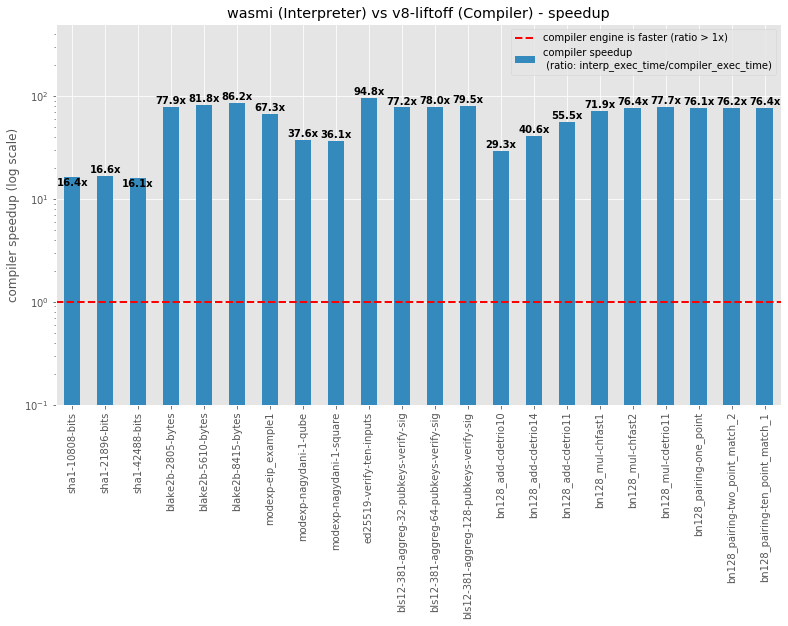

In [54]:
plotCompilerSpeedup(df_wasmi_v8liftoff, interp_name="wasmi", compiler_name="v8-liftoff")

## All precompiles compared (are interpreters feasible?)

In [55]:
def plotInterpOneEngine(df_benchdata, engine, test_names, title=""):
    df_bench = df_benchdata.loc[engine][df_benchdata.loc[engine]['test_name'].isin(test_names)]
    df_bench.set_index('test_name', inplace=True)
    df_bench = df_bench.reindex(test_names)
    plt.figure()
    ax = df_bench[['parse_time', 'exec_time']].plot.bar(stacked=True, figsize=(15,7), color=[COLORS_DEFAULT['red'], COLORS_DEFAULT['blue']])
    plt.ylabel("seconds")
    ax.set(xlabel='')
    # doing get_legend_handles_labels() so we can control the order of the labels in the legend 
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, ['execution time (top bar)', 'startup time (bottom bar)'])
    adjust_text_labels(labelBarHeights(ax))
    plt.suptitle(title, fontsize=16, y=0.95)
    plt.show()

<Figure size 432x288 with 0 Axes>

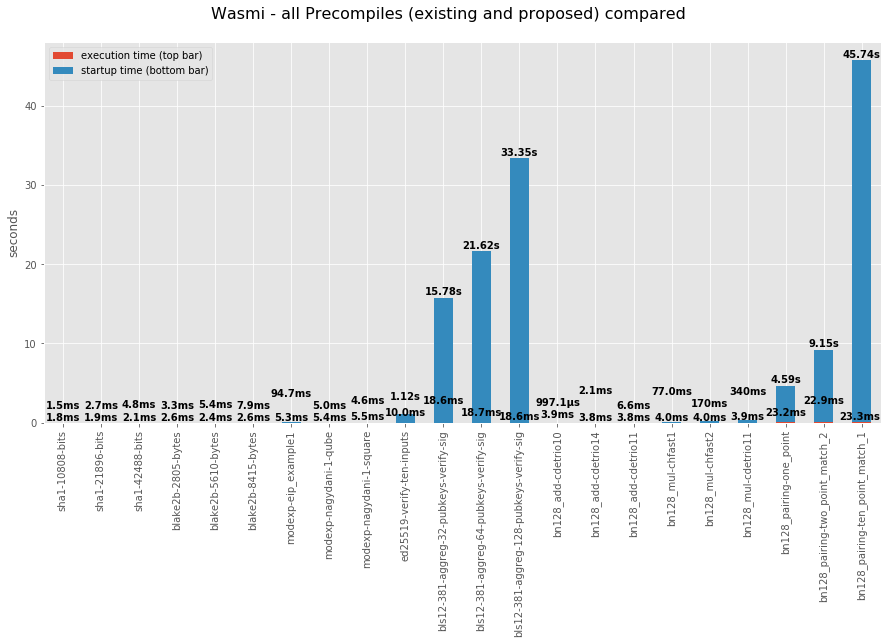

In [56]:
plotInterpOneEngine(df_interp, 'wasmi', all_tests, "Wasmi - all Precompiles (existing and proposed) compared")